
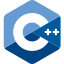
<br>

<div style="text-align:center; font-size:200%;">
 <b>Shared Pointer</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Akademie München</div>
<br/>
<!-- 21 Shared Pointer.ipynb -->
<!-- slides/module_160_raii/topic_140_shared_ptr.cpp -->


- Shared Pointers können *gemeinsam* Eigentümer eines Objekts sein
- Sie verwenden Reference-Counting

In [ ]:
#include <iostream>
#include <memory>
#include <vector>
#include <xcpp/xdisplay.hpp>

#include "lifetime_observer.hpp"
#include "print_info.hpp"

In [ ]:
std::shared_ptr<Obs> obs{};

In [ ]:
print_bool(obs);

In [ ]:
xcpp::display(obs.use_count());

In [ ]:
{
    std::shared_ptr<Obs> obs{std::make_shared<Obs>(1)};
    print_bool("obs", obs);
    print_use_count("obs", obs);
    std::shared_ptr<Obs> obs2{obs};
    print_use_count("obs", obs);
    print_use_count("obs2", obs2);
}

In [ ]:
{
    std::shared_ptr<Obs> obs{std::make_shared<Obs>(2)};
    std::shared_ptr<Obs> obs2{};
    print_use_count("obs  (outer block)", obs);
    print_use_count("obs2 (outer block)", obs2);
    {
        std::shared_ptr<Obs> obs3{obs};
        obs2 = obs3;
        print_use_count("obs  (inner block)", obs);
        print_use_count("obs2 (inner block)", obs2);
        print_use_count("obs3 (inner block)", obs3);
    }
    print_use_count("obs  (outer block, again)", obs);
    print_use_count("obs2 (outer block, again)", obs2);
    obs.reset();
    print_use_count("obs  (outer block, after reset)", obs);
    print_use_count("obs2 (outer block, after reset)", obs2);
}


## Shared Pointers und Funktionsaufrufe

In [ ]:
void describe(const Obs& obs) { std::cout << "describe(Obs&): " << obs << "\n"; }

In [ ]:
void describe(const Obs* obs) { std::cout << "describe(Obs*): " << obs << "\n"; }

In [ ]:
auto obs{std::make_shared<Obs>()};

In [ ]:
describe(*obs);

In [ ]:
describe(obs.get());


## Shared und Unique Pointers

- Ein Unique Pointer kann in einen Shared Pointer umgewandelt werden:

In [ ]:
std::unique_ptr<Obs> obs_up{std::make_unique<Obs>()};
std::shared_ptr<Obs> obs_sp{std::move(obs_up)};

In [ ]:
std::cout << obs_up.get() << "\n";
std::cout << obs_sp.get() << "\n";

In [ ]:
std::cout << *obs_sp;

In [ ]:
xcpp::display(obs_sp.use_count());


## Vorsicht bei Zyklen!

- Shared Pointer können Zyklen bilden
- Diese Zyklen werden nicht automatisch aufgelöst

In [ ]:
struct Cycle {
    ~Cycle() { std::cout << "Cycle::~Cycle()\n"; }
    std::shared_ptr<Cycle> other;
};

In [ ]:
{
    std::shared_ptr<Cycle> c1{std::make_shared<Cycle>()};
    std::shared_ptr<Cycle> c2{std::make_shared<Cycle>()};
    std::shared_ptr<Cycle> c3{std::make_shared<Cycle>()};
    c1->other = c2;
    c2->other = c1;
    print_use_count("c1", c1);
    print_use_count("c2", c2);
    print_use_count("c3", c3);
}


- Zum Auflösen von Zyklen kann man Weak Pointers einsetzen


## Enable Shared From This

- Wir übergeben typischerweise Argumente als Referenzen oder Raw Pointers
- Was ist, wenn wir einen Shared Pointer auf ein solches Objekt erzeugen
  wollen?
- Wir können **nicht** einfach den Konstruktor verwenden
- Wenn eine Klasse von `std::enable_shared_from_this` erbt, können wir die
  `shared_from_this()` Member-Funktion verwenden
- **Dazu muss das Objekt bereits von einem Shared Pointer verwaltet werden!**

In [ ]:
struct SharedFromThis : std::enable_shared_from_this<SharedFromThis> {
    Obs value{};
};

In [ ]:
std::vector<std::shared_ptr<SharedFromThis>> vec{};

In [ ]:
void StoreInVec(SharedFromThis& sft) { vec.push_back(sft.shared_from_this()); }

In [ ]:
auto sft{std::make_shared<SharedFromThis>()};

In [ ]:
StoreInVec(*sft);

In [ ]:
xcpp::display(vec[0]->value);
xcpp::display(sft->value);

In [ ]:
vec[0]->value = 42;

In [ ]:
xcpp::display(vec[0].use_count());
xcpp::display(vec[0]->value);
xcpp::display(sft->value);

In [ ]:
sft.reset();

In [ ]:
xcpp::display(vec[0].use_count());
xcpp::display(vec[0]->value);

In [ ]:
vec.clear();